In [23]:
library('tximport')
library('edgeR')
library('variancePartition')
library('BiocParallel')
library('pheatmap')


setwd("~/rnaseq/")

Loading required package: ggplot2

Loading required package: BiocParallel


Attaching package: ‘variancePartition’


The following object is masked from ‘package:limma’:

    topTable




In [14]:
design_df = read.table("~/rnaseq/design_set2p2.txt", header = T, sep = "\t")
rownames(design_df) = stringr::str_split_fixed(design_df$file, ".h5",2)[,1]
design_df$sample = rownames(design_df)
design_df$condition = as.factor(design_df$condition)
design_df$condition = relevel(design_df$condition, ref = "Safe-Harbor")
names(design_df) = c("path", "condition", "rep", "exp_day", "sample")

design_df = design_df[!(rownames(design_df) %in% c("MR86")),]

t2g = read.table("~/rnaseq/transcripts_to_genes.txt", stringsAsFactors = F, header=F, sep = "\t")
colnames(t2g) = c("target_id", "ens_gene", "gene_id")
t2g = t2g[,c("target_id","gene_id")]

design_df

,path,condition,rep,exp_day,sample
,<chr>,<fct>,<chr>,<int>,<chr>
MR82,MR82.h5,Safe-Harbor,rep1,1,MR82
MR83,MR83.h5,Safe-Harbor,rep2,1,MR83
MR87,MR87.h5,10-mer,rep2,1,MR87
MR86-2,MR86-2.h5,10-mer,rep3,2,MR86-2
MR95,MR95.h5,10-mer,rep1,2,MR95
MR96,MR96.h5,10-mer,rep2,2,MR96
MR97,MR97.h5,Safe-Harbor,rep1,2,MR97


In [15]:
files = paste0(rownames(design_df),".tsv")
names(files) = rownames(design_df)
files
txi <- tximport(files, type="kallisto", tx2gene=t2g, geneIdCol = "gene_name")


MR82         MR83         MR87       MR86-2         MR95         MR96 
  "MR82.tsv"   "MR83.tsv"   "MR87.tsv" "MR86-2.tsv"   "MR95.tsv"   "MR96.tsv" 
        MR97 
  "MR97.tsv"

Note: importing `abundance.h5` is typically faster than `abundance.tsv`

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 


transcripts missing from tx2gene: 17686

summarizing abundance

summarizing counts

summarizing length



In [26]:
library(edgeR)

x = txi$counts
isexpr = rowSums(cpm(x)>0) >= nrow(design_df)
sum(isexpr)
y = DGEList(counts = x[isexpr,])
y = calcNormFactors( y )

[1] 16943

In [27]:
param = SnowParam(6, "SOCK", progressbar=TRUE)

Dividing work into 102 chunks...

iteration: 
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102



Total:125 s



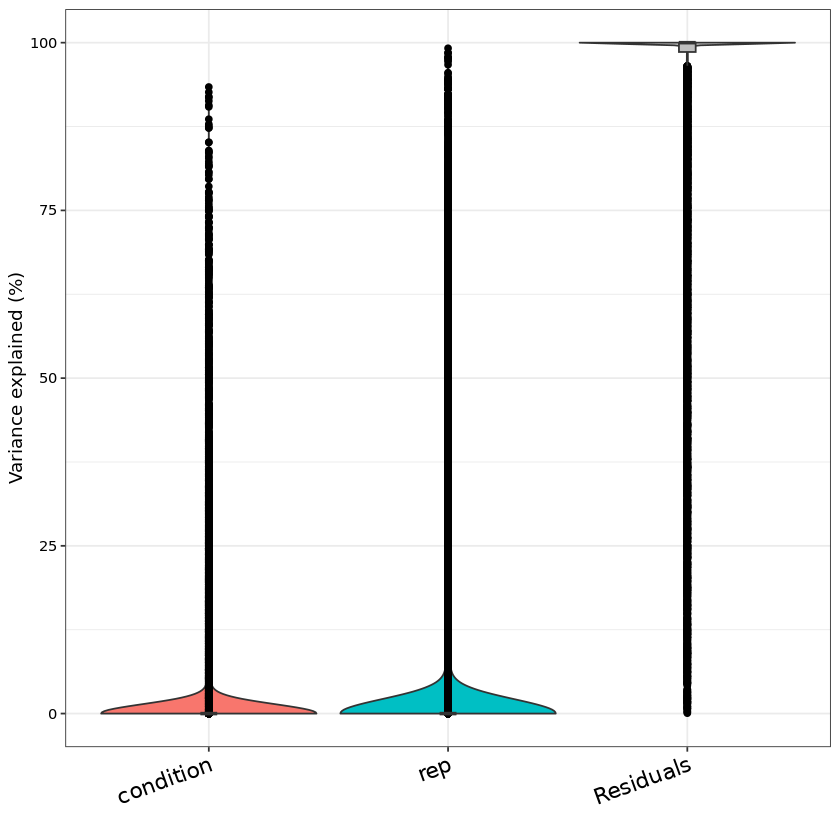

In [28]:
varPart <- fitExtractVarPartModel( cpm(y), ~ (1|condition) + (1|rep), design_df, BPPARAM=param )
vp <- sortCols( varPart )
plotVarPart( vp )

In [29]:
form <- ~ condition + (1|rep) 
vobjDream = voomWithDreamWeights( cpm(y), form, design_df, BPPARAM=param )


Memory usage to store result: >18.5 Mb

Dividing work into 102 chunks...

iteration: 
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102



Total:91 s



In [30]:
fitmm = dream( vobjDream, form, design_df, BPPARAM=param )


Dividing work into 102 chunks...

iteration: 
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102



Total:1162 s



In [31]:
fitmm = eBayes(fitmm)

In [ ]:
saveRDS(fitmm,"~/fitmm_sg4_rnaseq.rds")

In [ ]:
fitmm = readRDS("~/fitmm_sg4_rnaseq.rds")

In [34]:
topTable( fitmm, coef='condition10-mer', number = 10)

,logFC,AveExpr,t,P.Value,adj.P.Val,B,z.std
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AC008878.3,-1.3895890,4.13074966,-10.674146,2.484080e-26,4.208776e-22,-3.481807,-10.617003
AC119396.1,-1.0695359,3.50124412,-8.616937,1.058592e-17,8.967866e-14,-3.815740,-8.567387
AURKA,-0.5847279,6.48186857,-7.047380,1.873832e-12,1.058278e-08,-2.465648,-7.043564
CSRNP1,-0.9115927,3.92685536,-6.378811,1.919204e-10,8.129268e-07,-3.339643,-6.367671
HIST1H3B,0.6241362,-0.32562002,5.533752,3.306437e-08,9.687322e-05,-3.798468,5.524384
PARN,0.4600718,6.10142498,5.520043,3.430557e-08,9.687322e-05,-2.813451,5.517910
AC131160.1,-1.1628401,0.56800031,-5.414700,6.705786e-08,1.623088e-04,-3.984322,-5.398881
EGR1,-0.8120573,3.24546942,-4.901092,9.912670e-07,2.099380e-03,-3.677537,-4.893364
HIST1H1D,0.8157618,0.04539832,4.779973,1.803774e-06,3.395704e-03,-3.599314,4.774251


In [42]:
var_df_res = as.data.frame(topTable( fitmm, coef='condition10-mer', number = Inf))
var_df_res[which((abs(var_df_res$logFC) > 1) & (abs(var_df_res$z.std) > 3)),]

,logFC,AveExpr,t,P.Value,adj.P.Val,B,z.std
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AC008878.3,-1.389589,4.13074966,-10.674146,2.484080e-26,4.208776e-22,-3.481807,-10.617003
AC119396.1,-1.069536,3.50124412,-8.616937,1.058592e-17,8.967866e-14,-3.815740,-8.567387
AC131160.1,-1.162840,0.56800031,-5.414700,6.705786e-08,1.623088e-04,-3.984322,-5.398881
AC010970.1,1.022792,9.64057229,4.602107,4.204214e-06,5.479384e-03,-3.021667,4.601023
SMIM11B,-1.686460,1.58453042,-3.951629,7.953539e-05,6.416991e-02,-3.932707,-3.945796
GIMAP1-GIMAP5,-1.324931,2.00758560,-3.742925,1.868179e-04,9.309576e-02,-4.102506,-3.736206
COL12A1,1.263978,0.77652114,3.691047,2.271027e-04,1.012579e-01,-3.921068,3.686788
AP002748.4,-1.080638,0.01963858,-3.169963,1.535952e-03,3.817511e-01,-4.022349,-3.167804


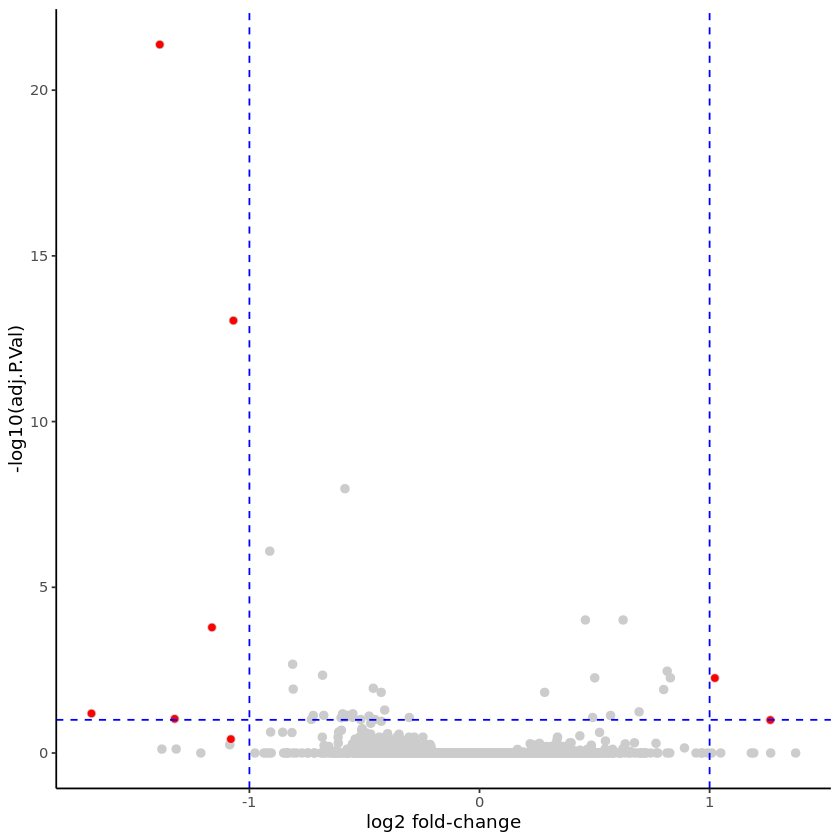

In [69]:
ggplot(data= var_df_res, aes(x= logFC, y= -log10(adj.P.Val))) +
     geom_point(colour= 'grey80', size = 2) +
     geom_point(data= var_df_res[which((abs(var_df_res$logFC) > 1) & (abs(var_df_res$z.std) > 3)),], colour= 'red') +
     geom_vline(xintercept= c(-1, 1), colour= 'blue', linetype= 'dashed') +
     geom_hline(yintercept= 1, colour= 'blue', linetype= 'dashed') +
     #geom_point(data= , colour= 'orange')
     xlab('log2 fold-change') +
     ylab('-log10(adj.P.Val)') +
     theme_classic()

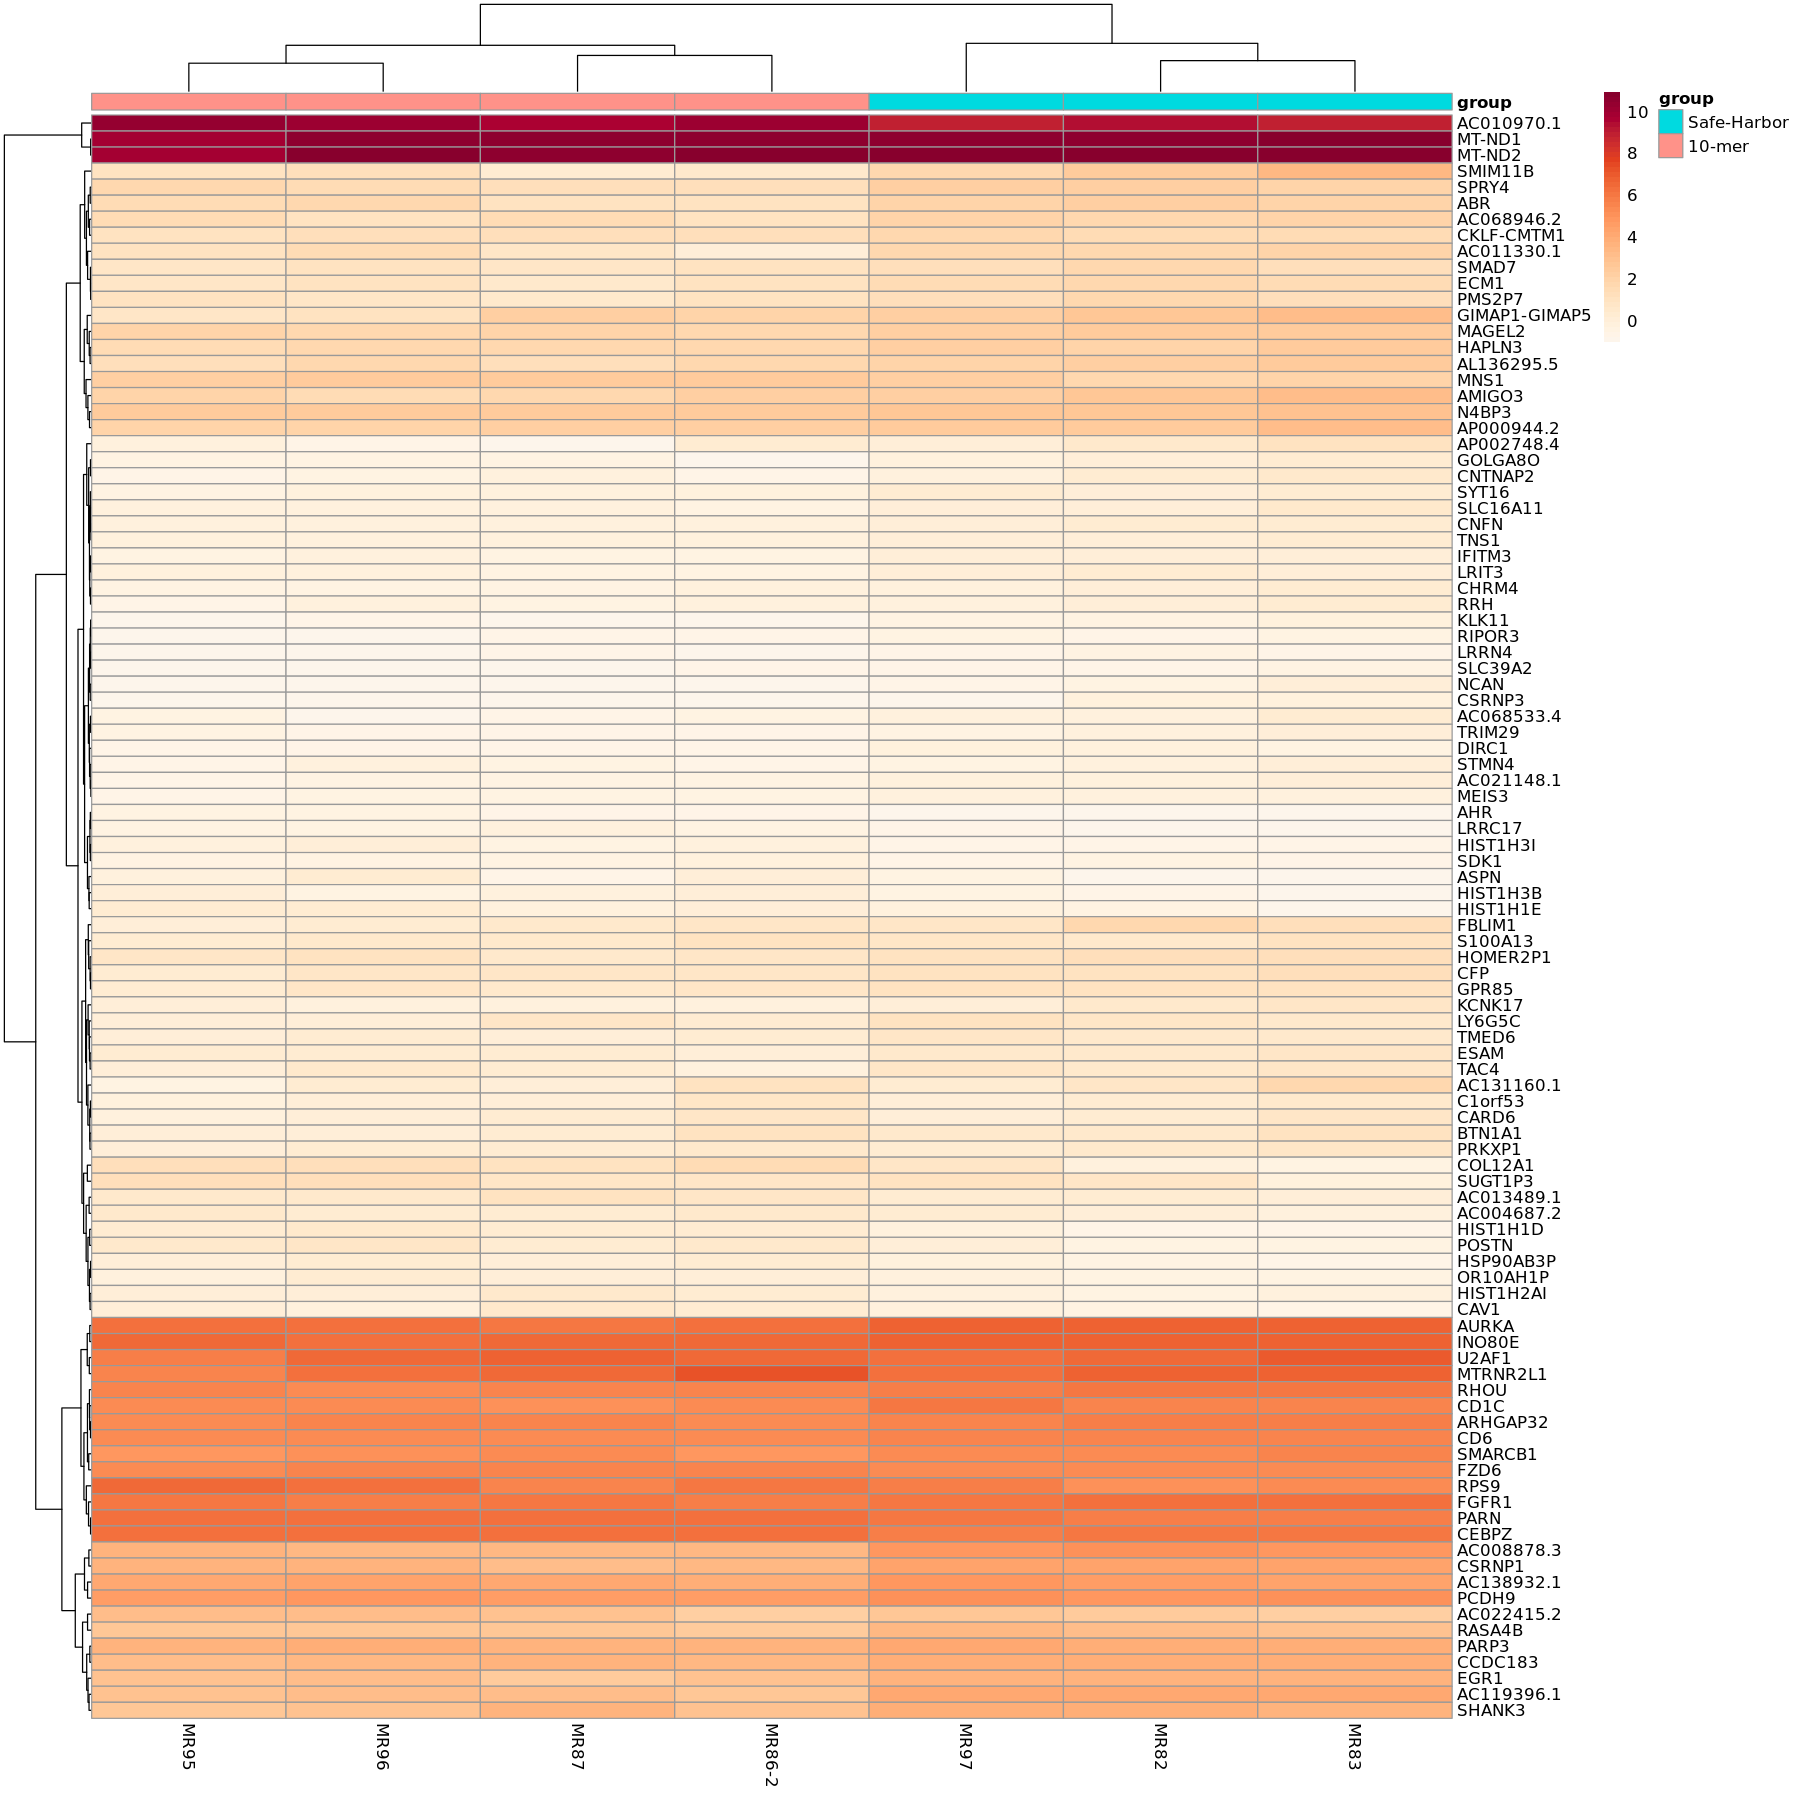

In [71]:
options(repr.plot.width=15, repr.plot.height=15)

anncol = data.frame(group = design_df$condition)
rownames(anncol) <- rownames(design_df)
pheatmap(mat = vobjDream$E[rownames(topTable( fitmm, coef='condition10-mer', number = 100)),], 
         cluster_cols = T, annotation_col = anncol,  color = hcl.colors(50, "OrRd", rev = T))